In [1]:
# Verification cell - run this in Jupyter
import sys
print("Python executable:", sys.executable)
print("Should contain your venv path\n")

try:
    import pandas as pd
    print("✅ pandas version:", pd.__version__)
except ImportError:
    print("❌ pandas not found")

try:
    import numpy as np
    print("✅ numpy version:", np.__version__)
except ImportError:
    print("❌ numpy not found")

try:
    import matplotlib.pyplot as plt
    print("✅ matplotlib version:", plt.matplotlib.__version__)
except ImportError:
    print("❌ matplotlib not found")

try:
    import seaborn as sns
    print("✅ seaborn version:", sns.__version__)
except ImportError:
    print("❌ seaborn not found")

print("\nIf all packages show ✅, you're ready to go!")

Python executable: /Users/fertostado/Documents/code/Fer/hugging-face-tests/huggingface-tests/.venv/bin/python
Should contain your venv path

✅ pandas version: 2.2.2
✅ numpy version: 1.26.4
✅ matplotlib version: 3.10.5
✅ seaborn version: 0.13.2

If all packages show ✅, you're ready to go!


In [5]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📊 Sales Analysis Dashboard - 2024 vs 2025")
print("=" * 50)

📊 Sales Analysis Dashboard - 2024 vs 2025


In [10]:
# Load the data
try:
    # Load both years' data
    df_2024 = pd.read_csv('./resources/ClientesTop_2024.csv')
    df_2025 = pd.read_csv('./resources/ClientesTop_2025.csv')
    
    # Add year column for identification
    df_2024['year'] = 2024
    df_2025['year'] = 2025
    
    print(f"✅ Data loaded successfully!")
    print(f"📋 2024 Records: {len(df_2024)}")
    print(f"📋 2025 Records: {len(df_2025)}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please ensure 'ClientsTop_2024.csv' and 'ClientsTop_2025.csv' are in the same directory")

✅ Data loaded successfully!
📋 2024 Records: 100
📋 2025 Records: 100


In [11]:
# Data cleaning and preprocessing
def clean_data(df):
    """Clean and standardize the data"""
    df = df.copy()
    
    # Clean client names - remove extra spaces and standardize
    df['nombre_Cliente'] = df['nombre_Cliente'].str.strip().str.upper()
    
    # Clean company names
    df['empresa'] = df['empresa'].str.strip().str.upper()
    
    # Ensure numeric columns are properly formatted
    df['total_Comprado'] = pd.to_numeric(df['total_Comprado'], errors='coerce')
    
    return df

df_2024_clean = clean_data(df_2024)
df_2025_clean = clean_data(df_2025)

print("\n🧹 Data cleaned and standardized")


🧹 Data cleaned and standardized


In [12]:
# Since we're in August 2025, let's calculate the projection factor
current_month = 8  # August
months_in_year = 12
projection_factor = months_in_year / current_month

print(f"\n📅 Projection Analysis:")
print(f"Current month: August (month {current_month})")
print(f"Projection factor for full year: {projection_factor:.2f}x")



📅 Projection Analysis:
Current month: August (month 8)
Projection factor for full year: 1.50x


In [13]:
# Create projected 2025 data
df_2025_projected = df_2025_clean.copy()
df_2025_projected['total_Comprado_projected'] = df_2025_projected['total_Comprado'] * projection_factor
df_2025_projected['year'] = '2025 (Projected)'

In [14]:
# 1. CLIENT COMPARISON ANALYSIS
print("\n" + "="*60)
print("📈 CLIENT COMPARISON ANALYSIS (2024 vs 2025)")
print("="*60)

# Aggregate by client
client_2024 = df_2024_clean.groupby('nombre_Cliente')['total_Comprado'].sum().reset_index()
client_2025 = df_2025_clean.groupby('nombre_Cliente')['total_Comprado'].sum().reset_index()
client_2025_proj = df_2025_projected.groupby('nombre_Cliente')['total_Comprado_projected'].sum().reset_index()

# Merge for comparison
client_comparison = client_2024.merge(
    client_2025, on='nombre_Cliente', how='outer', suffixes=('_2024', '_2025')
).merge(
    client_2025_proj[['nombre_Cliente', 'total_Comprado_projected']], 
    on='nombre_Cliente', how='outer'
)

# Fill NaN with 0
client_comparison = client_comparison.fillna(0)

# Calculate changes
client_comparison['change_actual'] = client_comparison['total_Comprado_2025'] - client_comparison['total_Comprado_2024']
client_comparison['change_projected'] = client_comparison['total_Comprado_projected'] - client_comparison['total_Comprado_2024']
client_comparison['pct_change_actual'] = (client_comparison['change_actual'] / client_comparison['total_Comprado_2024'] * 100).replace([np.inf, -np.inf], np.nan)
client_comparison['pct_change_projected'] = (client_comparison['change_projected'] / client_comparison['total_Comprado_2024'] * 100).replace([np.inf, -np.inf], np.nan)

# Sort by 2024 sales for ranking analysis
client_comparison = client_comparison.sort_values('total_Comprado_2024', ascending=False).reset_index(drop=True)
client_comparison['rank_2024'] = range(1, len(client_comparison) + 1)

# Rank for 2025 projected
client_comparison_rank_2025 = client_comparison.sort_values('total_Comprado_projected', ascending=False).reset_index(drop=True)
client_comparison_rank_2025['rank_2025_projected'] = range(1, len(client_comparison_rank_2025) + 1)

# Merge rankings
client_comparison = client_comparison.merge(
    client_comparison_rank_2025[['nombre_Cliente', 'rank_2025_projected']], 
    on='nombre_Cliente'
)
client_comparison['rank_change'] = client_comparison['rank_2024'] - client_comparison['rank_2025_projected']

# Display top clients comparison
print("\n🏆 TOP 10 CLIENTS COMPARISON:")
top_clients = client_comparison.head(10)[['nombre_Cliente', 'total_Comprado_2024', 'total_Comprado_2025', 
                                         'total_Comprado_projected', 'pct_change_projected', 'rank_2024', 
                                         'rank_2025_projected', 'rank_change']]

for idx, row in top_clients.iterrows():
    print(f"\n{idx+1}. {row['nombre_Cliente']}")
    print(f"   2024: ${row['total_Comprado_2024']:,.2f}")
    print(f"   2025 (Aug): ${row['total_Comprado_2025']:,.2f}")
    print(f"   2025 (Projected): ${row['total_Comprado_projected']:,.2f}")
    print(f"   Change: {row['pct_change_projected']:.1f}% | Rank: {row['rank_2024']} → {row['rank_2025_projected']} ({row['rank_change']:+d})")


📈 CLIENT COMPARISON ANALYSIS (2024 vs 2025)

🏆 TOP 10 CLIENTS COMPARISON:

1. TV REY
   2024: $4,768,334.89
   2025 (Aug): $2,547,094.00
   2025 (Projected): $3,820,641.00
   Change: -19.9% | Rank: 1 → 1 (+0)

2. CLAUDIA
   2024: $2,336,193.92
   2025 (Aug): $0.00
   2025 (Projected): $0.00
   Change: -100.0% | Rank: 2 → 135 (-133)

3. GABRIELA
   2024: $474,793.00
   2025 (Aug): $0.00
   2025 (Projected): $0.00
   Change: -100.0% | Rank: 3 → 103 (-100)

4. BENJAMÍN
   2024: $443,712.00
   2025 (Aug): $320,317.00
   2025 (Projected): $480,475.50
   Change: 8.3% | Rank: 4 → 7 (-3)

5. OCTAVIO
   2024: $355,267.42
   2025 (Aug): $203,156.00
   2025 (Projected): $304,734.00
   Change: -14.2% | Rank: 5 → 12 (-7)

6. ALFONSO
   2024: $352,200.00
   2025 (Aug): $0.00
   2025 (Projected): $0.00
   Change: -100.0% | Rank: 6 → 99 (-93)

7. CARMEN
   2024: $328,520.00
   2025 (Aug): $0.00
   2025 (Projected): $0.00
   Change: -100.0% | Rank: 7 → 95 (-88)

8. JOSE ANTONIO
   2024: $320,200.00
  

In [15]:
# 2. ENTERPRISE ANALYSIS
print("\n" + "="*60)
print("🏢 ENTERPRISE ANALYSIS")
print("="*60)

# Aggregate by enterprise
enterprise_2024 = df_2024_clean.groupby('empresa')['total_Comprado'].sum().reset_index()
enterprise_2025 = df_2025_clean.groupby('empresa')['total_Comprado'].sum().reset_index()
enterprise_2025_proj = df_2025_projected.groupby('empresa')['total_Comprado_projected'].sum().reset_index()

# Merge for comparison
enterprise_comparison = enterprise_2024.merge(
    enterprise_2025, on='empresa', how='outer', suffixes=('_2024', '_2025')
).merge(
    enterprise_2025_proj[['empresa', 'total_Comprado_projected']], 
    on='empresa', how='outer'
)

enterprise_comparison = enterprise_comparison.fillna(0)
enterprise_comparison['change_projected'] = enterprise_comparison['total_Comprado_projected'] - enterprise_comparison['total_Comprado_2024']
enterprise_comparison['pct_change_projected'] = (enterprise_comparison['change_projected'] / enterprise_comparison['total_Comprado_2024'] * 100).replace([np.inf, -np.inf], np.nan)

# Sort by projected 2025 sales
enterprise_comparison = enterprise_comparison.sort_values('total_Comprado_projected', ascending=False)

print("\n🏆 ENTERPRISE RANKING (2025 Projected):")
for idx, row in enterprise_comparison.iterrows():
    print(f"{list(enterprise_comparison.index).index(idx)+1}. {row['empresa']}")
    print(f"   2024: ${row['total_Comprado_2024']:,.2f}")
    print(f"   2025 (Projected): ${row['total_Comprado_projected']:,.2f}")
    print(f"   Change: {row['pct_change_projected']:.1f}%")


🏢 ENTERPRISE ANALYSIS

🏆 ENTERPRISE RANKING (2025 Projected):
1. TESLA COMUNICACIONES
   2024: $10,106,206.80
   2025 (Projected): $11,190,284.58
   Change: 10.7%
2. DAHUA MEXICO
   2024: $7,072,089.61
   2025 (Projected): $6,472,005.00
   Change: -8.5%
3. HIKVISION MEXICO
   2024: $2,169,503.00
   2025 (Projected): $2,309,055.81
   Change: 6.4%
4. MERCA ELÉCTRICO
   2024: $0.00
   2025 (Projected): $859,456.27
   Change: nan%



📊 GENERATING VISUALIZATIONS


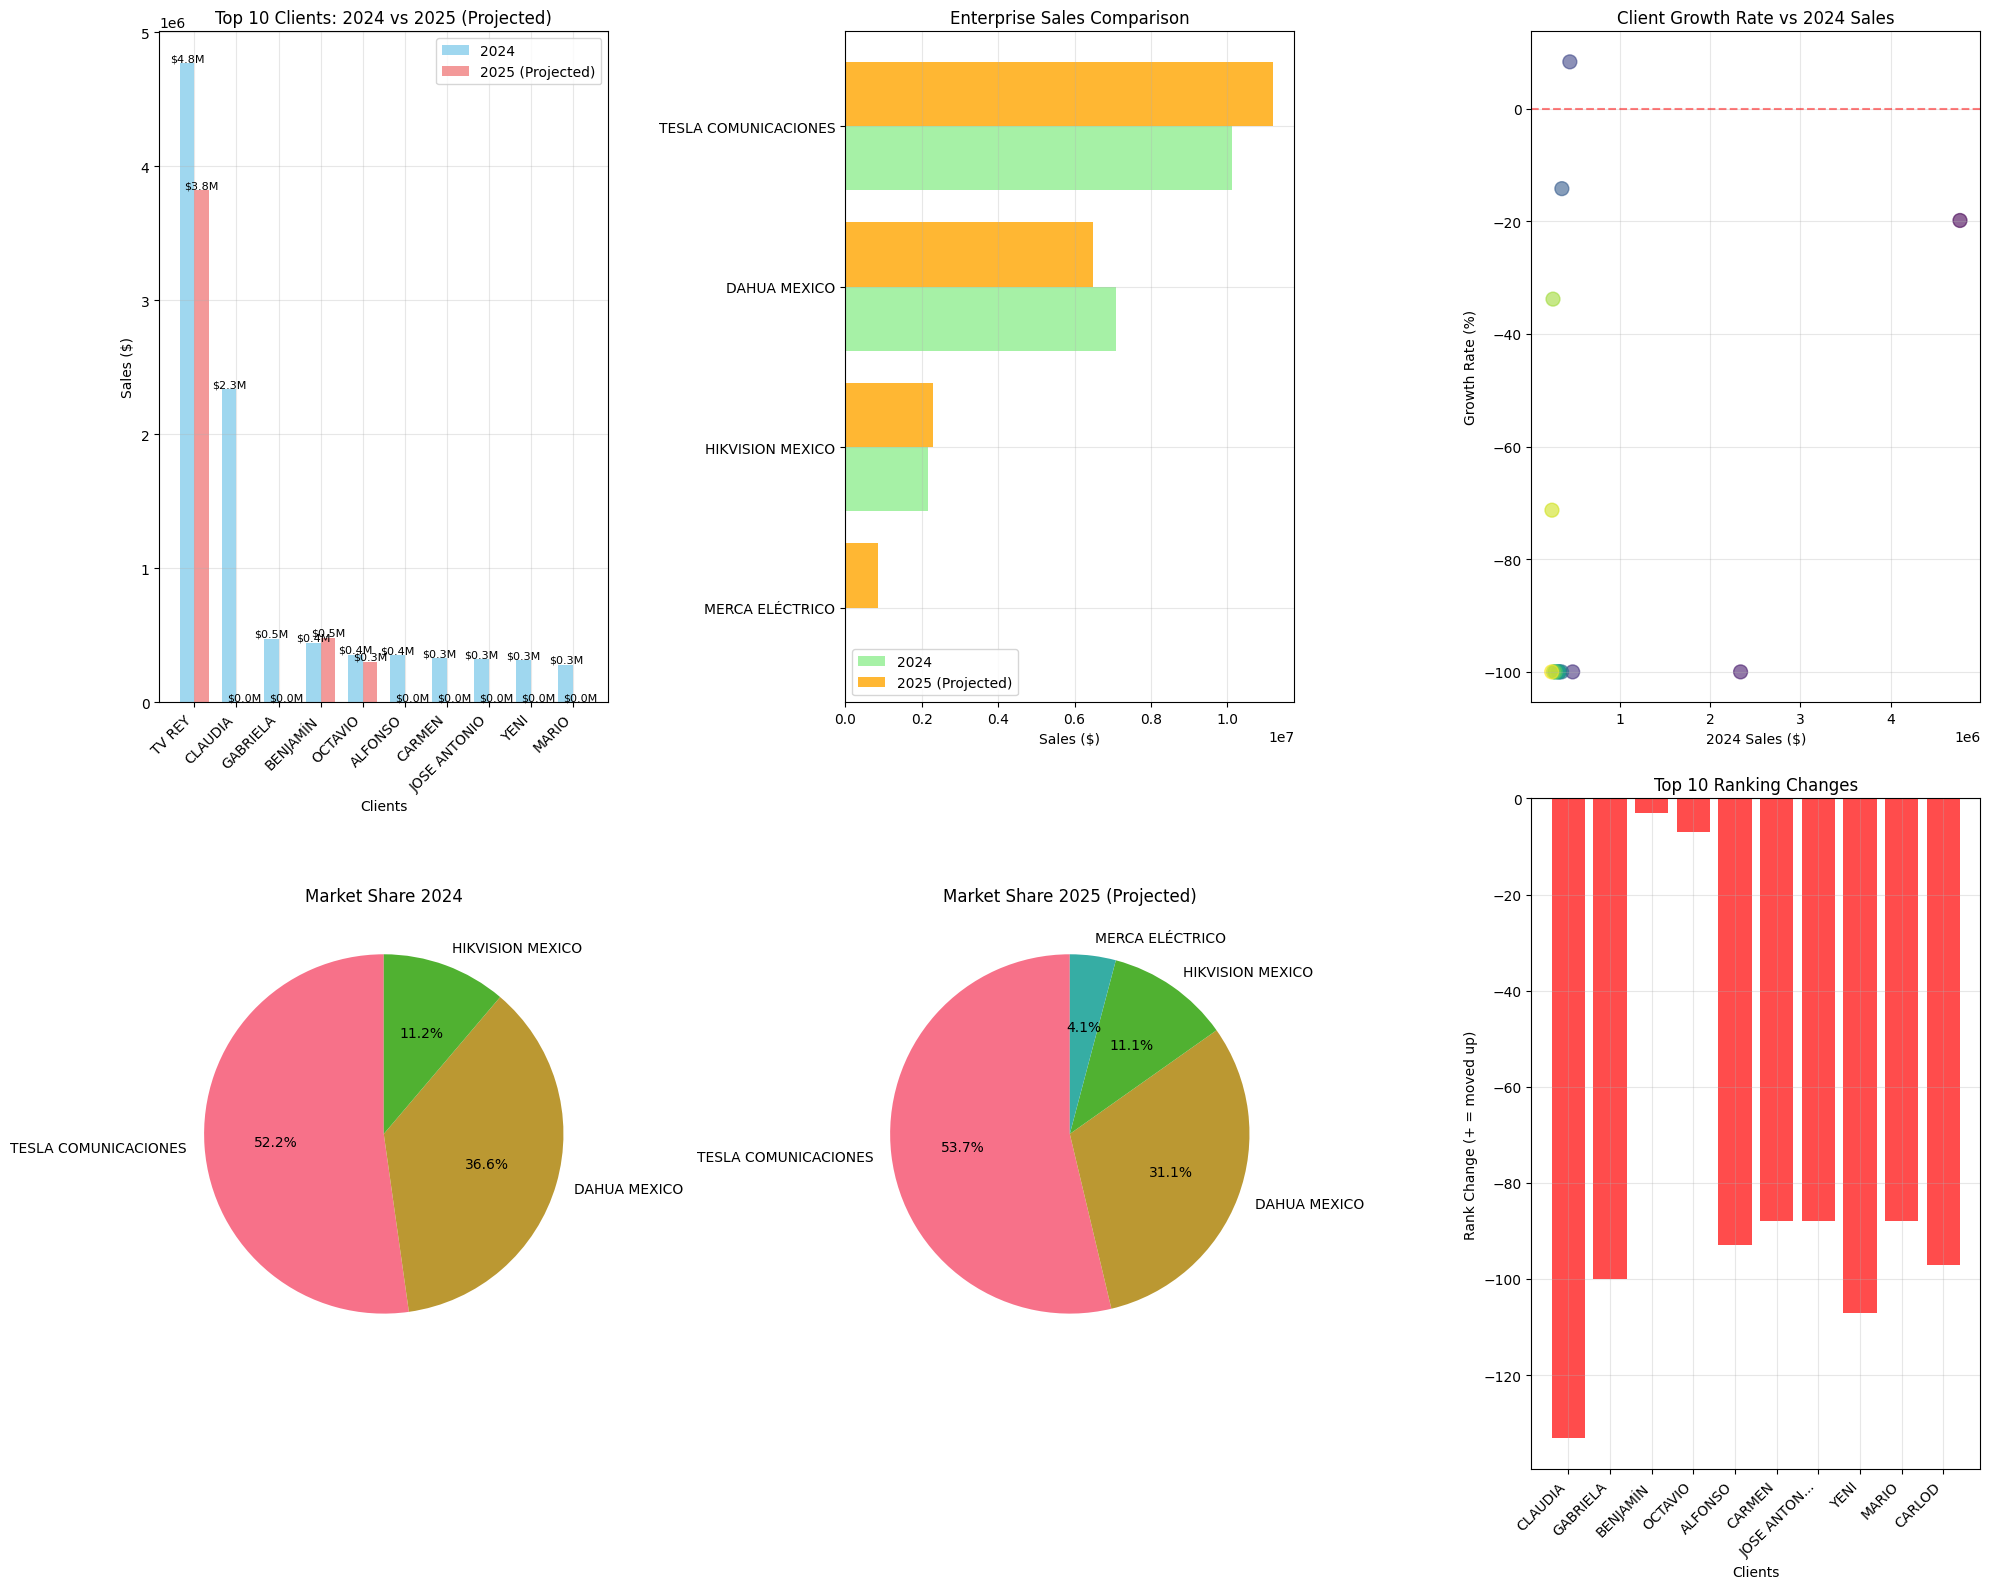

In [16]:
# 3. VISUALIZATION SECTION
print("\n" + "="*60)
print("📊 GENERATING VISUALIZATIONS")
print("="*60)

# Create subplots
fig = plt.figure(figsize=(20, 16))

# 1. Top 10 Clients Comparison
ax1 = plt.subplot(2, 3, 1)
top_10_clients = client_comparison.head(10)
x = np.arange(len(top_10_clients))
width = 0.35

bars1 = ax1.bar(x - width/2, top_10_clients['total_Comprado_2024'], width, 
                label='2024', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, top_10_clients['total_Comprado_projected'], width, 
                label='2025 (Projected)', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Clients')
ax1.set_ylabel('Sales ($)')
ax1.set_title('Top 10 Clients: 2024 vs 2025 (Projected)')
ax1.set_xticks(x)
ax1.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                     for name in top_10_clients['nombre_Cliente']], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height/1000000:.1f}M', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${height/1000000:.1f}M', ha='center', va='bottom', fontsize=8)

# 2. Enterprise Comparison
ax2 = plt.subplot(2, 3, 2)
enterprise_data = enterprise_comparison.sort_values('total_Comprado_projected', ascending=True)
y_pos = np.arange(len(enterprise_data))

bars1 = ax2.barh(y_pos - 0.2, enterprise_data['total_Comprado_2024'], 0.4, 
                 label='2024', alpha=0.8, color='lightgreen')
bars2 = ax2.barh(y_pos + 0.2, enterprise_data['total_Comprado_projected'], 0.4, 
                 label='2025 (Projected)', alpha=0.8, color='orange')

ax2.set_yticks(y_pos)
ax2.set_yticklabels(enterprise_data['empresa'])
ax2.set_xlabel('Sales ($)')
ax2.set_title('Enterprise Sales Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Growth Rate Analysis
ax3 = plt.subplot(2, 3, 3)
growth_data = client_comparison[client_comparison['total_Comprado_2024'] > 0].head(15)
scatter = ax3.scatter(growth_data['total_Comprado_2024'], 
                      growth_data['pct_change_projected'],
                      s=100, alpha=0.6, c=range(len(growth_data)), cmap='viridis')
ax3.set_xlabel('2024 Sales ($)')
ax3.set_ylabel('Growth Rate (%)')
ax3.set_title('Client Growth Rate vs 2024 Sales')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 4. Market Share Pie Chart 2024
ax4 = plt.subplot(2, 3, 4)
enterprise_2024_sorted = enterprise_2024.sort_values('total_Comprado', ascending=False)
ax4.pie(enterprise_2024_sorted['total_Comprado'], 
        labels=enterprise_2024_sorted['empresa'], 
        autopct='%1.1f%%', startangle=90)
ax4.set_title('Market Share 2024')

# 5. Market Share Pie Chart 2025 (Projected)
ax5 = plt.subplot(2, 3, 5)
enterprise_2025_sorted = enterprise_comparison.sort_values('total_Comprado_projected', ascending=False)
ax5.pie(enterprise_2025_sorted['total_Comprado_projected'], 
        labels=enterprise_2025_sorted['empresa'], 
        autopct='%1.1f%%', startangle=90)
ax5.set_title('Market Share 2025 (Projected)')

# 6. Ranking Changes
ax6 = plt.subplot(2, 3, 6)
ranking_changes = client_comparison[client_comparison['rank_change'] != 0].head(10)
colors = ['green' if x > 0 else 'red' for x in ranking_changes['rank_change']]
bars = ax6.bar(range(len(ranking_changes)), ranking_changes['rank_change'], color=colors, alpha=0.7)
ax6.set_xlabel('Clients')
ax6.set_ylabel('Rank Change (+ = moved up)')
ax6.set_title('Top 10 Ranking Changes')
ax6.set_xticks(range(len(ranking_changes)))
ax6.set_xticklabels([name[:10] + '...' if len(name) > 10 else name 
                     for name in ranking_changes['nombre_Cliente']], rotation=45, ha='right')
ax6.grid(True, alpha=0.3)
ax6.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# 4. SUMMARY INSIGHTS
print("\n" + "="*60)
print("📋 KEY INSIGHTS & RECOMMENDATIONS")
print("="*60)

total_2024 = df_2024_clean['total_Comprado'].sum()
total_2025_actual = df_2025_clean['total_Comprado'].sum()
total_2025_projected = df_2025_projected['total_Comprado_projected'].sum()

print(f"\n💰 TOTAL SALES SUMMARY:")
print(f"2024 Total: ${total_2024:,.2f}")
print(f"2025 YTD (Aug): ${total_2025_actual:,.2f}")
print(f"2025 Projected: ${total_2025_projected:,.2f}")
print(f"YoY Growth (Projected): {((total_2025_projected - total_2024) / total_2024 * 100):.1f}%")

print(f"\n🔍 CLIENT INSIGHTS:")
# New vs Lost clients
clients_2024 = set(df_2024_clean['nombre_Cliente'].unique())
clients_2025 = set(df_2025_clean['nombre_Cliente'].unique())
new_clients = clients_2025 - clients_2024
lost_clients = clients_2024 - clients_2025

print(f"New clients in 2025: {len(new_clients)}")
if new_clients:
    print(f"  - {', '.join(list(new_clients)[:5])}" + ("..." if len(new_clients) > 5 else ""))

print(f"Lost clients from 2024: {len(lost_clients)}")
if lost_clients:
    print(f"  - {', '.join(list(lost_clients)[:5])}" + ("..." if len(lost_clients) > 5 else ""))

# Top performers
top_grower = client_comparison[client_comparison['pct_change_projected'] == client_comparison['pct_change_projected'].max()]
if not top_grower.empty:
    print(f"\n🚀 Highest growth client: {top_grower.iloc[0]['nombre_Cliente']} (+{top_grower.iloc[0]['pct_change_projected']:.1f}%)")

# Market leader
market_leader_2024 = enterprise_2024.loc[enterprise_2024['total_Comprado'].idxmax(), 'empresa']
market_leader_2025 = enterprise_comparison.loc[enterprise_comparison['total_Comprado_projected'].idxmax(), 'empresa']

print(f"\n🏆 MARKET LEADERSHIP:")
print(f"2024 Leader: {market_leader_2024}")
print(f"2025 Leader (Projected): {market_leader_2025}")
if market_leader_2024 != market_leader_2025:
    print("⚠️  Market leadership has changed!")

print(f"\n📊 RECOMMENDATIONS:")
print("1. Focus on retaining high-growth clients identified in the analysis")
print("2. Investigate why certain clients were lost and develop retention strategies")
print("3. Analyze the success factors of top-performing enterprises")
print("4. Monitor the projected vs actual performance as the year progresses")
print("5. Consider seasonal adjustments to the projection model")

# Export results for stakeholder presentation
client_comparison.to_csv('client_analysis_2024_2025.csv', index=False)
enterprise_comparison.to_csv('enterprise_analysis_2024_2025.csv', index=False)

print(f"\n💾 Analysis exported to CSV files for stakeholder presentation")
print("Files created: 'client_analysis_2024_2025.csv', 'enterprise_analysis_2024_2025.csv'")

print(f"\n✅ Analysis Complete! Use these insights for your stakeholder presentation.")


📋 KEY INSIGHTS & RECOMMENDATIONS

💰 TOTAL SALES SUMMARY:
2024 Total: $19,347,799.41
2025 YTD (Aug): $13,887,201.11
2025 Projected: $20,830,801.66
YoY Growth (Projected): 7.7%

🔍 CLIENT INSIGHTS:
New clients in 2025: 68
  - MANUEL, LUIS FERNANDO, RENÉ, CLAUDIA S., JOSÉ ANTONIO...
Lost clients from 2024: 68
  - MONICA, YI-PIN, JOSE ANTONIO, HIPOLITO, FELIPE DE JESÚS...

🚀 Highest growth client: RITA (+705.6%)

🏆 MARKET LEADERSHIP:
2024 Leader: TESLA COMUNICACIONES
2025 Leader (Projected): TESLA COMUNICACIONES

📊 RECOMMENDATIONS:
1. Focus on retaining high-growth clients identified in the analysis
2. Investigate why certain clients were lost and develop retention strategies
3. Analyze the success factors of top-performing enterprises
4. Monitor the projected vs actual performance as the year progresses
5. Consider seasonal adjustments to the projection model

💾 Analysis exported to CSV files for stakeholder presentation
Files created: 'client_analysis_2024_2025.csv', 'enterprise_analysis